In [37]:
# -*- coding: utf-8 -*-
# Import packages

# Database and cloud storage
import psycopg2
import gcsfs
from google.oauth2 import service_account
from google.cloud import storage

# Asynchronous operations
import aiohttp
import ssl
import certifi
import asyncio
import nest_asyncio

# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl

# Machine learning and preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, cross_val_predict
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

# Machine learning models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Deep learning with TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier


# Loding Data 

# Loding Data 

In [2]:
# Read the merged CSV file
merged_file_path = '/Users/tyh/Desktop/Coding/thesis/data/thesis_aki_patients_classci.csv'
df = pd.read_csv(merged_file_path)

df.head()

,subject_id,confirm_aki_time,gender,final_deathtime,survival_days,aki_age,bmi,after_aki_icu_num,after_aki_bun_max,after_aki_bun_min,...,platelet_max,platelet_min,wbc_max,wbc_min,bicarbonate_max,bicarbonate_min,sp_o2_max,sp_o2_min,urine_output_max,urine_output_min
0,11467,2177-07-23T02:30:00,1,2179-02-11T00:00:00,567.90,23.0,NaN,2.0,NaN,NaN,...,94.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,74857,2111-09-04T01:46:00,1,2112-10-30T12:38:00,422.45,26.0,61.34,5.0,NaN,NaN,...,308.0,24.0,NaN,NaN,NaN,NaN,3540.00,-9.0,NaN,NaN
2,11353,2113-05-30T04:20:00,1,2113-06-17T07:46:00,18.14,25.0,NaN,1.0,NaN,NaN,...,163.0,14.0,NaN,NaN,NaN,NaN,15778.00,-91.0,NaN,NaN
3,11723,2177-12-23T12:45:00,0,NaN,NaN,32.0,52.53,3.0,NaN,NaN,...,218.0,5.0,NaN,NaN,NaN,NaN,2700.00,-4.0,NaN,NaN
4,26313,2128-03-11T20:09:00,1,2130-09-18T00:00:00,920.16,29.0,NaN,2.0,NaN,NaN,...,505.0,31.0,NaN,NaN,NaN,NaN,3680.75,-15.0,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26900 entries, 0 to 26899
Data columns (total 53 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   subject_id                  26900 non-null  int64  
 1   confirm_aki_time            26900 non-null  object 
 2   gender                      26900 non-null  int64  
 3   final_deathtime             12309 non-null  object 
 4   survival_days               12309 non-null  float64
 5   aki_age                     26900 non-null  float64
 6   bmi                         5973 non-null   float64
 7   after_aki_icu_num           26840 non-null  float64
 8   after_aki_bun_max           0 non-null      float64
 9   after_aki_bun_min           0 non-null      float64
 10  after_aki_creatinine_max    26840 non-null  float64
 11  after_aki_creatinine_min    26840 non-null  float64
 12  after_aki_glucose_max       26629 non-null  float64
 13  after_aki_glucose_min       266

# survival risk category

In [4]:
def categorize_survival_days(days):
    if days <= 200:
        return '0'  #Short-term survival
    elif 200 < days <= 800:
        return '1'  #Medium-term survival
    elif 800 < days <= 1500:
        return '2'  #Long-term survival
    else:
        return '3'  #Very long-term survival
    
# the categorize of  survival_days 
df['survival_category'] = df['survival_days'].apply(categorize_survival_days)

In [5]:
# Calculate the number of each category in survival_category
compute_df_category_counts = df['survival_category'].value_counts()

# Calculation ratio
compute_df_total_samples = len(df)
compute_df_category_proportions = compute_df_category_counts / compute_df_total_samples

print(compute_df_category_counts)
print(compute_df_category_proportions)

survival_category
3    16132
0     6813
1     2538
2     1417
Name: count, dtype: int64
survival_category
3    0.599703
0    0.253271
1    0.094349
2    0.052677
Name: count, dtype: float64


# Drop the columns that are not needed

In [6]:
df_extracted = df.drop(columns=['confirm_aki_time', 'final_deathtime'])
df_extracted

,subject_id,gender,survival_days,aki_age,bmi,after_aki_icu_num,after_aki_bun_max,after_aki_bun_min,after_aki_creatinine_max,after_aki_creatinine_min,...,platelet_min,wbc_max,wbc_min,bicarbonate_max,bicarbonate_min,sp_o2_max,sp_o2_min,urine_output_max,urine_output_min,survival_category
0,11467,1,567.90,23.0,NaN,2.0,NaN,NaN,3.7,0.4,...,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,74857,1,422.45,26.0,61.34,5.0,NaN,NaN,4.9,0.7,...,24.0,NaN,NaN,NaN,NaN,3540.00000,-9.0,NaN,NaN,1
2,11353,1,18.14,25.0,NaN,1.0,NaN,NaN,4.9,0.8,...,14.0,NaN,NaN,NaN,NaN,15778.00000,-91.0,NaN,NaN,0
3,11723,0,NaN,32.0,52.53,3.0,NaN,NaN,3.8,0.6,...,5.0,NaN,NaN,NaN,NaN,2700.00000,-4.0,NaN,NaN,3
4,26313,1,920.16,29.0,NaN,2.0,NaN,NaN,4.8,0.6,...,31.0,NaN,NaN,NaN,NaN,3680.75000,-15.0,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26895,23118,0,NaN,87.0,NaN,1.0,NaN,NaN,1.8,0.9,...,151.0,NaN,NaN,NaN,NaN,2463.77002,-8.0,NaN,NaN,3
26896,16013,0,606.50,87.0,NaN,3.0,NaN,NaN,1.8,0.9,...,181.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
26897,15370,0,1264.28,87.0,NaN,1.0,NaN,NaN,1.8,0.7,...,120.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
26898,6345,0,1830.48,87.0,NaN,1.0,NaN,NaN,1.8,1.5,...,292.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3


### check missing value

In [7]:
# missing values
missing_values = df_extracted.isnull().sum()
print("the num of missing_values:")
print(missing_values)

the num of missing_values:
subject_id                        0
gender                            0
survival_days                 14591
aki_age                           0
bmi                           20927
after_aki_icu_num                60
after_aki_bun_max             26900
after_aki_bun_min             26900
after_aki_creatinine_max         60
after_aki_creatinine_min         60
after_aki_glucose_max           271
after_aki_glucose_min           271
after_aki_potassium_max          68
after_aki_potassium_min          68
after_aki_calcium_max         26900
after_aki_calcium_min         26900
after_aki_hemoglobin_max      26900
after_aki_hemoglobin_min      26900
after_aki_platelet_max          211
after_aki_platelet_min          211
after_aki_wbc_max             26900
after_aki_wbc_min             26900
after_aki_bicarbonate_max     26900
after_aki_bicarbonate_min     26900
after_aki_sp_o2_max           13014
after_aki_sp_o2_min           13014
after_aki_urine_output_max    26900
a

# Prcessing the missing values

#### Firstly， Remove columns with all values as missing values, then to ensure data robustness, patients are deleted if more than 50 per cent of their data is missing

In [8]:
 # Remove all columns with missing values
df_cleaned = df_extracted.dropna(axis=1, how='all')

# print the shape of the cleaned DataFrame
print("Shape after removal of all empty columns:", df_cleaned.shape)

Shape after removal of all empty columns: (26900, 28)


#### Secondly, set threshold = 0.5 for missing values

In [9]:
# Set the threshold for missing values
threshold = 0.5  # Set the threshold for missing values
df_cleaned_new = df_cleaned.dropna(thresh=int(threshold * df_cleaned.shape[1]))

df_cleaned_new

,subject_id,gender,survival_days,aki_age,bmi,after_aki_icu_num,after_aki_creatinine_max,after_aki_creatinine_min,after_aki_glucose_max,after_aki_glucose_min,...,creatinine_min,glucose_max,glucose_min,potassium_max,potassium_min,platelet_max,platelet_min,sp_o2_max,sp_o2_min,survival_category
0,11467,1,567.90,23.0,NaN,2.0,3.7,0.4,250.0,73.0,...,0.4,250.0,73.0,6.3,3.3,94.0,16.0,NaN,NaN,1
1,74857,1,422.45,26.0,61.34,5.0,4.9,0.7,713.0,70.0,...,0.7,713.0,70.0,7.1,2.9,308.0,24.0,3540.00000,-9.0,1
2,11353,1,18.14,25.0,NaN,1.0,4.9,0.8,447.0,30.0,...,0.8,447.0,30.0,6.5,2.5,163.0,14.0,15778.00000,-91.0,0
3,11723,0,NaN,32.0,52.53,3.0,3.8,0.6,173.0,82.0,...,0.6,173.0,82.0,5.3,3.1,218.0,5.0,2700.00000,-4.0,3
4,26313,1,920.16,29.0,NaN,2.0,4.8,0.6,177.0,63.0,...,0.6,177.0,63.0,6.5,3.2,505.0,31.0,3680.75000,-15.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26895,23118,0,NaN,87.0,NaN,1.0,1.8,0.9,267.0,104.0,...,0.9,267.0,104.0,5.0,2.6,341.0,151.0,2463.77002,-8.0,3
26896,16013,0,606.50,87.0,NaN,3.0,1.8,0.9,368.0,55.0,...,0.9,368.0,55.0,6.5,3.7,251.0,181.0,NaN,NaN,1
26897,15370,0,1264.28,87.0,NaN,1.0,1.8,0.7,100.0,72.0,...,0.7,100.0,72.0,5.8,2.9,250.0,120.0,NaN,NaN,2
26898,6345,0,1830.48,87.0,NaN,1.0,1.8,1.5,137.0,97.0,...,1.5,137.0,97.0,4.4,3.9,389.0,292.0,NaN,NaN,3


In [17]:
df_cleaned_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26870 entries, 0 to 26899
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   subject_id                26870 non-null  int64  
 1   gender                    26870 non-null  int64  
 2   survival_days             12297 non-null  float64
 3   aki_age                   26870 non-null  float64
 4   bmi                       5972 non-null   float64
 5   after_aki_icu_num         26839 non-null  float64
 6   after_aki_creatinine_max  26839 non-null  float64
 7   after_aki_creatinine_min  26839 non-null  float64
 8   after_aki_glucose_max     26628 non-null  float64
 9   after_aki_glucose_min     26628 non-null  float64
 10  after_aki_potassium_max   26831 non-null  float64
 11  after_aki_potassium_min   26831 non-null  float64
 12  after_aki_platelet_max    26688 non-null  float64
 13  after_aki_platelet_min    26688 non-null  float64
 14  after_aki_s

# Completing missing values，using MICE to fill

In [10]:
# Select the value column
numeric_columns = df_cleaned_new.select_dtypes(include=[float, int]).columns
# Using MICE to Fill in Missing Values in Value Columns
mice_imputer = IterativeImputer(max_iter=10, random_state=42, imputation_order='ascending', initial_strategy='mean')

df_numeric_imputed = pd.DataFrame(mice_imputer.fit_transform(df_cleaned_new[numeric_columns]), columns=numeric_columns)

df_numeric_imputed

/Users/tyh/Library/Python/3.12/lib/python/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,subject_id,gender,survival_days,aki_age,bmi,after_aki_icu_num,after_aki_creatinine_max,after_aki_creatinine_min,after_aki_glucose_max,after_aki_glucose_min,...,creatinine_max,creatinine_min,glucose_max,glucose_min,potassium_max,potassium_min,platelet_max,platelet_min,sp_o2_max,sp_o2_min
0,11467.0,1.0,567.900000,23.0,1508.345460,2.0,3.7,0.4,250.0,73.0,...,3.7,0.4,250.0,73.0,6.3,3.3,94.0,16.0,7833.111405,-23.842287
1,74857.0,1.0,422.450000,26.0,61.340000,5.0,4.9,0.7,713.0,70.0,...,4.9,0.7,713.0,70.0,7.1,2.9,308.0,24.0,3540.000000,-9.000000
2,11353.0,1.0,18.140000,25.0,2725.131293,1.0,4.9,0.8,447.0,30.0,...,4.9,0.8,447.0,30.0,6.5,2.5,163.0,14.0,15778.000000,-91.000000
3,11723.0,0.0,1171.046154,32.0,52.530000,3.0,3.8,0.6,173.0,82.0,...,3.8,0.6,173.0,82.0,5.3,3.1,218.0,5.0,2700.000000,-4.000000
4,26313.0,1.0,920.160000,29.0,215.826048,2.0,4.8,0.6,177.0,63.0,...,4.8,0.6,177.0,63.0,6.5,3.2,505.0,31.0,3680.750000,-15.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26865,23118.0,0.0,428.850084,87.0,874.672640,1.0,1.8,0.9,267.0,104.0,...,1.8,0.9,267.0,104.0,5.0,2.6,341.0,151.0,2463.770020,-8.000000
26866,16013.0,0.0,606.500000,87.0,1413.695937,3.0,1.8,0.9,368.0,55.0,...,1.8,0.9,368.0,55.0,6.5,3.7,251.0,181.0,13383.810617,-13.090306
26867,15370.0,0.0,1264.280000,87.0,-1590.271308,1.0,1.8,0.7,100.0,72.0,...,1.8,0.7,100.0,72.0,5.8,2.9,250.0,120.0,-17091.800527,-10.791404
26868,6345.0,0.0,1830.480000,87.0,-2289.881076,1.0,1.8,1.5,137.0,97.0,...,1.8,1.5,137.0,97.0,4.4,3.9,389.0,292.0,-19966.247374,11.160904


In [11]:
# Check if there are still missing values in the filled DataFrame
final_missing_values = df_numeric_imputed.isnull().sum()
print("Missing value statistics after filling:")
print(final_missing_values)

Missing value statistics after filling:
subject_id                  0
gender                      0
survival_days               0
aki_age                     0
bmi                         0
after_aki_icu_num           0
after_aki_creatinine_max    0
after_aki_creatinine_min    0
after_aki_glucose_max       0
after_aki_glucose_min       0
after_aki_potassium_max     0
after_aki_potassium_min     0
after_aki_platelet_max      0
after_aki_platelet_min      0
after_aki_sp_o2_max         0
after_aki_sp_o2_min         0
icu_num                     0
creatinine_max              0
creatinine_min              0
glucose_max                 0
glucose_min                 0
potassium_max               0
potassium_min               0
platelet_max                0
platelet_min                0
sp_o2_max                   0
sp_o2_min                   0
dtype: int64


# Data Exploration

In [20]:
df_numeric_imputed.describe()

,subject_id,gender,survival_days,aki_age,bmi,after_aki_icu_num,after_aki_creatinine_max,after_aki_creatinine_min,after_aki_glucose_max,after_aki_glucose_min,...,creatinine_max,creatinine_min,glucose_max,glucose_min,potassium_max,potassium_min,platelet_max,platelet_min,sp_o2_max,sp_o2_min
count,26870.000000,26870.000000,26870.000000,26870.000000,26870.000000,26870.000000,26870.000000,26870.000000,26870.000000,26870.000000,...,26870.000000,26870.000000,26870.000000,26870.000000,26870.000000,26870.000000,26870.000000,26870.000000,2.687000e+04,26870.000000
mean,37130.786677,0.571120,493.125099,64.110421,551.951191,1.462556,2.221302,1.015956,257.476530,85.105315,...,2.219439,0.961349,272.275454,82.274138,5.188505,3.408200,359.931873,152.887702,7.282514e+03,-12.232758
std,29058.434137,0.494925,1262.612015,18.245394,3635.251740,1.201106,5.497820,0.947266,219.811379,28.041120,...,5.496976,0.913773,228.343996,24.375554,1.039136,0.465652,190.447673,85.736822,1.292277e+05,76.995335
min,3.000000,0.000000,-178517.813846,0.000000,-9652.390451,0.928486,0.000000,0.000000,-61.414502,-251.000000,...,0.000000,0.000000,-57.223288,-251.000000,2.900000,0.800000,9.000000,4.000000,-5.526316e+05,-10069.000000
25%,13495.250000,0.000000,65.831167,53.000000,53.552500,1.000000,1.000000,0.600000,150.000000,70.000000,...,1.000000,0.500000,160.000000,69.000000,4.500000,3.100000,232.000000,97.000000,1.600000e+03,-11.061952
50%,27029.500000,1.000000,390.390334,67.000000,464.864254,1.000000,1.400000,0.800000,189.000000,84.000000,...,1.400000,0.700000,198.000000,83.000000,4.900000,3.400000,317.000000,142.500000,3.000000e+03,-5.000000
75%,60791.000000,1.000000,686.318017,78.000000,1071.651757,2.000000,2.300000,1.100000,259.000000,97.000000,...,2.300000,1.000000,272.000000,94.000000,5.600000,3.700000,442.000000,197.000000,7.592033e+03,-1.000000
max,99999.000000,1.000000,24944.742833,90.000000,535266.540000,40.000000,808.000000,17.600000,3565.000000,643.000000,...,808.000000,16.000000,3565.000000,500.000000,27.500000,9.000000,2315.000000,876.000000,9.999999e+06,83.706111


### Defination the categorize of survival_days 

In [12]:
def categorize_survival_days(days):
    if days <= 200:
        return '0'  #Short-term survival
    elif 200 < days <= 800:
        return '1'  #Medium-term survival
    elif 800 < days <= 1500:
        return '2'  #Long-term survival
    else:
        return '3'  #Very long-term survival
    
# the categorize of  survival_days 
df_numeric_imputed['survival_category'] = df_numeric_imputed['survival_days'].apply(categorize_survival_days)

df_numeric_imputed.head()

,subject_id,gender,survival_days,aki_age,bmi,after_aki_icu_num,after_aki_creatinine_max,after_aki_creatinine_min,after_aki_glucose_max,after_aki_glucose_min,...,creatinine_min,glucose_max,glucose_min,potassium_max,potassium_min,platelet_max,platelet_min,sp_o2_max,sp_o2_min,survival_category
0,11467.0,1.0,567.900000,23.0,1508.345460,2.0,3.7,0.4,250.0,73.0,...,0.4,250.0,73.0,6.3,3.3,94.0,16.0,7833.111405,-23.842287,1
1,74857.0,1.0,422.450000,26.0,61.340000,5.0,4.9,0.7,713.0,70.0,...,0.7,713.0,70.0,7.1,2.9,308.0,24.0,3540.000000,-9.000000,1
2,11353.0,1.0,18.140000,25.0,2725.131293,1.0,4.9,0.8,447.0,30.0,...,0.8,447.0,30.0,6.5,2.5,163.0,14.0,15778.000000,-91.000000,0
3,11723.0,0.0,1171.046154,32.0,52.530000,3.0,3.8,0.6,173.0,82.0,...,0.6,173.0,82.0,5.3,3.1,218.0,5.0,2700.000000,-4.000000,2
4,26313.0,1.0,920.160000,29.0,215.826048,2.0,4.8,0.6,177.0,63.0,...,0.6,177.0,63.0,6.5,3.2,505.0,31.0,3680.750000,-15.000000,2


In [22]:
# Calculate the number of each category in survival_category
category_counts = df_numeric_imputed['survival_category'].value_counts()

# Calculation ratio
total_samples = len(df)
category_proportions = category_counts / total_samples

print(category_counts)
print(category_proportions)

survival_category
1    12440
0     9881
2     2946
3     1603
Name: count, dtype: int64
survival_category
1    0.462454
0    0.367323
2    0.109517
3    0.059591
Name: count, dtype: float64


### Normalisation, min - max

In [13]:
# min
columns_to_normalize = [
    'bmi', 
    'after_aki_creatinine_max', 'after_aki_creatinine_min',
    'after_aki_glucose_max', 'after_aki_glucose_min',
    'after_aki_potassium_max', 'after_aki_potassium_min',
    'after_aki_platelet_max', 'after_aki_platelet_min',
    'after_aki_sp_o2_max', 'after_aki_sp_o2_min',
    'creatinine_max', 'creatinine_min',
    'glucose_max', 'glucose_min',
    'potassium_max', 'potassium_min',
    'platelet_max', 'platelet_min',
    'sp_o2_max', 'sp_o2_min'
]

# 初始化 MinMaxScaler
scaler = MinMaxScaler()

# 对指定列进行归一化，结果存储在一个新的 DataFrame 中
df_final = df_numeric_imputed.copy()
df_final[columns_to_normalize] = scaler.fit_transform(df_numeric_imputed[columns_to_normalize])

df_final

,subject_id,gender,survival_days,aki_age,bmi,after_aki_icu_num,after_aki_creatinine_max,after_aki_creatinine_min,after_aki_glucose_max,after_aki_glucose_min,...,creatinine_min,glucose_max,glucose_min,potassium_max,potassium_min,platelet_max,platelet_min,sp_o2_max,sp_o2_min,survival_category
0,11467.0,1.0,567.900000,23.0,0.020481,2.0,0.004579,0.022727,0.085874,0.362416,...,0.02500,0.084816,0.431425,0.138211,0.304878,0.036860,0.013761,0.053111,0.989407,1
1,74857.0,1.0,422.450000,26.0,0.017826,5.0,0.006064,0.039773,0.213548,0.359060,...,0.04375,0.212638,0.427430,0.170732,0.256098,0.129662,0.022936,0.052705,0.990869,1
2,11353.0,1.0,18.140000,25.0,0.022714,1.0,0.006064,0.045455,0.140198,0.314318,...,0.05000,0.139203,0.374168,0.146341,0.207317,0.066782,0.011468,0.053864,0.982792,0
3,11723.0,0.0,1171.046154,32.0,0.017810,3.0,0.004703,0.034091,0.064641,0.372483,...,0.03750,0.063559,0.443409,0.097561,0.280488,0.090633,0.001147,0.052625,0.991361,2
4,26313.0,1.0,920.160000,29.0,0.018110,2.0,0.005941,0.034091,0.065744,0.351230,...,0.03750,0.064663,0.418109,0.146341,0.292683,0.215091,0.030963,0.052718,0.990278,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26865,23118.0,0.0,428.850084,87.0,0.019319,1.0,0.002228,0.051136,0.090562,0.397092,...,0.05625,0.089509,0.472703,0.085366,0.219512,0.143972,0.168578,0.052603,0.990967,1
26866,16013.0,0.0,606.500000,87.0,0.020308,3.0,0.002228,0.051136,0.118413,0.342282,...,0.05625,0.117393,0.407457,0.146341,0.353659,0.104944,0.202982,0.053637,0.990466,1
26867,15370.0,0.0,1264.280000,87.0,0.014795,1.0,0.002228,0.039773,0.044511,0.361298,...,0.04375,0.043405,0.430093,0.117886,0.256098,0.104510,0.133028,0.050749,0.990692,2
26868,6345.0,0.0,1830.480000,87.0,0.013511,1.0,0.002228,0.085227,0.054714,0.389262,...,0.09375,0.053620,0.463382,0.060976,0.378049,0.164788,0.330275,0.050477,0.992855,3


In [22]:
df_numeric_imputed

,subject_id,gender,survival_days,aki_age,bmi,after_aki_icu_num,after_aki_creatinine_max,after_aki_creatinine_min,after_aki_glucose_max,after_aki_glucose_min,...,creatinine_min,glucose_max,glucose_min,potassium_max,potassium_min,platelet_max,platelet_min,sp_o2_max,sp_o2_min,survival_category
0,11467.0,1.0,567.900000,23.0,1508.345460,2.0,3.7,0.4,250.0,73.0,...,0.4,250.0,73.0,6.3,3.3,94.0,16.0,7833.111405,-23.842287,1
1,74857.0,1.0,422.450000,26.0,61.340000,5.0,4.9,0.7,713.0,70.0,...,0.7,713.0,70.0,7.1,2.9,308.0,24.0,3540.000000,-9.000000,1
2,11353.0,1.0,18.140000,25.0,2725.131293,1.0,4.9,0.8,447.0,30.0,...,0.8,447.0,30.0,6.5,2.5,163.0,14.0,15778.000000,-91.000000,0
3,11723.0,0.0,1171.046154,32.0,52.530000,3.0,3.8,0.6,173.0,82.0,...,0.6,173.0,82.0,5.3,3.1,218.0,5.0,2700.000000,-4.000000,2
4,26313.0,1.0,920.160000,29.0,215.826048,2.0,4.8,0.6,177.0,63.0,...,0.6,177.0,63.0,6.5,3.2,505.0,31.0,3680.750000,-15.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26865,23118.0,0.0,428.850084,87.0,874.672640,1.0,1.8,0.9,267.0,104.0,...,0.9,267.0,104.0,5.0,2.6,341.0,151.0,2463.770020,-8.000000,1
26866,16013.0,0.0,606.500000,87.0,1413.695937,3.0,1.8,0.9,368.0,55.0,...,0.9,368.0,55.0,6.5,3.7,251.0,181.0,13383.810617,-13.090306,1
26867,15370.0,0.0,1264.280000,87.0,-1590.271308,1.0,1.8,0.7,100.0,72.0,...,0.7,100.0,72.0,5.8,2.9,250.0,120.0,-17091.800527,-10.791404,2
26868,6345.0,0.0,1830.480000,87.0,-2289.881076,1.0,1.8,1.5,137.0,97.0,...,1.5,137.0,97.0,4.4,3.9,389.0,292.0,-19966.247374,11.160904,3


### Data imbalance exists, oversampling using SMOTE, and split the dataset into training and test sets, finally, perform feature standardisation

In [14]:
# Selection of features and target variables
features = [
    'gender','bmi','aki_age', 
    'after_aki_creatinine_max', 'after_aki_creatinine_min',
    'after_aki_glucose_max', 'after_aki_glucose_min',
    'after_aki_potassium_max', 'after_aki_potassium_min',
    'after_aki_platelet_max', 'after_aki_platelet_min',
    'after_aki_sp_o2_max', 'after_aki_sp_o2_min',
    'creatinine_max', 'creatinine_min',
    'glucose_max', 'glucose_min',
    'potassium_max', 'potassium_min',
    'platelet_max', 'platelet_min',
    'sp_o2_max', 'sp_o2_min'
    ]
    
X = df_final[features]
y = df_final['survival_category']

# Encoding the target variable as a number
y = y.astype('category').cat.codes

# oversampling using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Perform feature standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# LR Model Part 

## Fit model

In [ ]:
# Create logistic regression model and train it
lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)
lr_model.fit(X_train_scaled, y_train)

# Predictions on test sets
y_pred_lr = lr_model.predict(X_test_scaled)

# Calculating Accuracy, Precision, Recall and F1 Scores
accuracy = accuracy_score(y_test, y_pred_lr)
precision = precision_score(y_test, y_pred_lr, average='weighted')
recall = recall_score(y_test, y_pred_lr, average='weighted')
f1 = f1_score(y_test, y_pred_lr, average='weighted')

# print Performance Score
print("Model Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# print Confusion Matrix and Classification Report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, digits=4)) # set the number of decimal places to 4

## 10-fold cross validation and GridSearch

In [ ]:
# Define the parameter grid for the logistic regression model
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # 正则化参数
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],  # 求解器
    'max_iter': [100, 200, 300]  # 最大迭代次数
}

# Creating a logistic regressionl model
lr = LogisticRegression(multi_class='multinomial', random_state=42)

# Setting Grid Search Parameters
lr_grid_search = GridSearchCV(
    estimator=lr,
    param_grid=lr_param_grid,
    cv=10,  # 10折交叉验证
    scoring='accuracy',  # 使用准确率作为评价指标
    n_jobs=-1,  # 使用所有可用的CPU核心
    verbose=2
)

lr_grid_search.fit(X_train_scaled, y_train)

# print the best parameters and best model score
print("Best parameters found: ", lr_grid_search.best_params_)
print("Best cross-validation accuracy: ", lr_grid_search.best_score_)

## Using the best parameters to repeat prediction

In [ ]:
# use the best model to make predictions
lr_best_model = lr_grid_search.best_estimator_
y_pred_lr = lr_best_model.predict(X_test_scaled)

# Calculating Accuracy, Precision, Recall and F1 Scores
accuracy = accuracy_score(y_test, y_pred_lr)
precision = precision_score(y_test, y_pred_lr, average='weighted')
recall = recall_score(y_test, y_pred_lr, average='weighted')
f1 = f1_score(y_test, y_pred_lr, average='weighted')

# print Performance Score
print("\nModel Performance Metrics on Test Data:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# print Confusion Matrix and Classification Report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, digits=4)) # set the number of decimal places to 4

### Accuracy of LR model hyperparametric combinations

In [ ]:
# import openpyxl

# the results of the grid search
lr_results = pd.DataFrame(lr_grid_search.cv_results_)

# the accuray of cross validation select hyperparametric combinations 
lr_results_acc = lr_results[['params', 'mean_test_score', 'std_test_score']]

lr_results_acc

# save the results to an Excel file to local
lr_results_acc.to_excel('lr_grid_search_results.xlsx', index=False)

print("Results saved to 'lr_grid_search_results.xlsx'")

In [25]:
# 
lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200, random_state=42)

# 10-fold cross-validation to compute the accuracy of the model
cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=10, scoring='accuracy', n_jobs=-1)

# Calculate the average accuracy
mean_accuracy = cv_scores.mean()

# print the accuracy of each fold and the average accuracy
print(f"Per-fold accuracy for 10-fold cross validation: {cv_scores}")
print(f"Average accuracy of 10-fold cross-validation: {mean_accuracy:.4f}")

0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0

10折交叉验证的每折准确率: [0.6802311  0.67219292 0.67143934 0.66993218 0.67696559 0.67897513
 0.68475257 0.69153479 0.67236181 0.68944724]
10折交叉验证的平均准确率: 0.6788


## LR - AUC-ROC Curve

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

# 4 classes
n_classes = 4
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2, 3])

# 10-fold cross-validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store the micro-average and weighted-average AUC values
micro_aucs = []
weighted_aucs = []

for train_idx, val_idx in kfold.split(X_train_scaled, y_train):
    # Indexing with NumPy arrays to avoid Pandas indexing errors
    X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_train_fold, y_val_fold = y_train_binarized[train_idx], y_train_binarized[val_idx]
    
    lr_model.fit(X_train_fold, y_train[train_idx])
    y_pred_fold = lr_model.predict_proba(X_val_fold)
    
    micro_auc_fold = roc_auc_score(y_val_fold, y_pred_fold, average='micro')
    weighted_auc_fold = roc_auc_score(y_val_fold, y_pred_fold, average='weighted')
    
    micro_aucs.append(micro_auc_fold)
    weighted_aucs.append(weighted_auc_fold)

# Calculate the mean and standard deviation of the AUC values
micro_auc_cv_mean = np.mean(micro_aucs)
micro_auc_cv_std = np.std(micro_aucs)
weighted_auc_cv_mean = np.mean(weighted_aucs)
weighted_auc_cv_std = np.std(weighted_aucs)

print(f"10-Fold Cross-Validation Micro-Average AUC: Mean = {micro_auc_cv_mean:.4f}, Std Dev = {micro_auc_cv_std:.4f}")
print(f"10-Fold Cross-Validation Weighted-Average AUC: Mean = {weighted_auc_cv_mean:.4f}, Std Dev = {weighted_auc_cv_std:.4f}")

In [ ]:
# Initialize lists to store the FPR and TPR values for each fold
fprs_micro = []
tprs_micro = []
fprs_weighted = []
tprs_weighted = []

# plt roc curve
plt.figure(figsize=(10, 8))

for train_idx, val_idx in kfold.split(X_train_scaled, y_train):
    X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_train_fold, y_val_fold = y_train_binarized[train_idx], y_train_binarized[val_idx]
    
    lr_model.fit(X_train_fold, y_train[train_idx])
    y_pred_fold = lr_model.predict_proba(X_val_fold)
    
    # compute Micro-Average ROC curve
    fpr_micro, tpr_micro, _ = roc_curve(y_val_fold.ravel(), y_pred_fold.ravel())
    fprs_micro.append(fpr_micro)
    tprs_micro.append(np.interp(np.linspace(0, 1, 100), fpr_micro, tpr_micro))
    
    # compute Weighted-Average ROC curve
    fpr_weighted, tpr_weighted, _ = roc_curve(y_val_fold.ravel(), y_pred_fold.ravel())
    fprs_weighted.append(fpr_weighted)
    tprs_weighted.append(np.interp(np.linspace(0, 1, 100), fpr_weighted, tpr_weighted))

# Micro-Average ROC curve
mean_fpr_micro = np.linspace(0, 1, 100)
mean_tpr_micro = np.mean(tprs_micro, axis=0)
mean_tpr_micro[-1] = 1.0
micro_auc = auc(mean_fpr_micro, mean_tpr_micro)

plt.plot(mean_fpr_micro, mean_tpr_micro, color='blue', lw=4,  # 
         label=f'Micro-Average ROC (AUC = {micro_auc_cv_mean:.4f} ± {micro_auc_cv_std:.4f})')

# Weighted-Average ROC curve
mean_fpr_weighted = np.linspace(0, 1, 100)
mean_tpr_weighted = np.mean(tprs_weighted, axis=0)
mean_tpr_weighted[-1] = 1.0
weighted_auc = auc(mean_fpr_weighted, mean_tpr_weighted)

plt.plot(mean_fpr_weighted, mean_tpr_weighted, color='red', lw=2, 
         label=f'Weighted-Average ROC (AUC = {weighted_auc_cv_mean:.4f} ± {weighted_auc_cv_std:.4f})')

# 45-degree line
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', lw=2)

# drop the grid
plt.grid(False)

# set the x and y axis limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('ROC Curve for 10-Fold Cross-Validation', fontsize=18)
plt.legend(loc="lower right", fontsize=12)

# print plot
plt.show()

## the best parameters AUC

In [ ]:
# Binarize the test labels for AUC calculation
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# Fit the best model on the training data
y_pred_best = lr_best_model.predict_proba(X_test_scaled)

# Compute the Micro-Average AUC and Weighted-Average AUC
n_bootstrap = 1000
micro_aucs_bootstrap = []
weighted_aucs_bootstrap = []

for i in range(n_bootstrap):
    indices = np.random.choice(np.arange(len(y_test)), size=len(y_test), replace=True)
    y_test_sample = y_test_binarized[indices]
    y_pred_sample = y_pred_best[indices]
    
    micro_auc_bootstrap = roc_auc_score(y_test_sample, y_pred_sample, average='micro')
    weighted_auc_bootstrap = roc_auc_score(y_test_sample, y_pred_sample, average='weighted')
    
    micro_aucs_bootstrap.append(micro_auc_bootstrap)
    weighted_aucs_bootstrap.append(weighted_auc_bootstrap)

# Calculate the mean and standard deviation of the AUC values
micro_auc_best_mean = np.mean(micro_aucs_bootstrap)
micro_auc_best_std = np.std(micro_aucs_bootstrap)
weighted_auc_best_mean = np.mean(weighted_aucs_bootstrap)
weighted_auc_best_std = np.std(weighted_aucs_bootstrap)

print(f"Best Model Micro-Average AUC: Mean = {micro_auc_best_mean:.4f}, Std Dev = {micro_auc_best_std:.4f}")
print(f"Best Model Weighted-Average AUC: Mean = {weighted_auc_best_mean:.4f}, Std Dev = {weighted_auc_best_std:.4f}")

In [ ]:
# Binarize the test labels for AUC calculation
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# Fit the best model on the training data
y_pred_best = lr_best_model.predict_proba(X_test_scaled)

# compute Micro-Average ROC curve
fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), y_pred_best.ravel())
micro_auc = auc(fpr_micro, tpr_micro)

# compute Weighted-Average ROC curve
fpr_weighted, tpr_weighted, _ = roc_curve(y_test_binarized.ravel(), y_pred_best.ravel())
weighted_auc = auc(fpr_weighted, tpr_weighted)

# plt roc curve 
plt.figure(figsize=(10, 8))

# Micro-Average ROC curve
plt.plot(fpr_micro, tpr_micro, color='blue', lw=5, 
         label=f'Micro-Average ROC (AUC = {micro_auc_best_mean:.4f} ± {micro_auc_best_std:.4f})')

# Weighted-Average ROC curve
plt.plot(fpr_weighted, tpr_weighted, color='red', lw=2, 
         label=f'Weighted-Average ROC (AUC = {weighted_auc_best_mean:.4f} ± {weighted_auc_best_std:.4f})')

# 45-degree line
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', lw=2)

# drop the grid
plt.grid(False)

# set the x and y axis limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('ROC Curve for Best Model on Test Data', fontsize=18)
plt.legend(loc="lower right", fontsize=12)

# plt 
plt.show()


# SVM Model Part

In [26]:
# create svm model and fit it
svm_classifier = SVC(kernel='rbf', decision_function_shape='ovo', random_state=42)
svm_classifier.fit(X_train_scaled, y_train)

# Predictions on test sets
y_pred_svm = svm_classifier.predict(X_test_scaled)

# Calculating Accuracy, Precision, Recall and F1 Scores
accuracy = accuracy_score(y_test, y_pred_lr)
precision = precision_score(y_test, y_pred_lr, average='weighted')
recall = recall_score(y_test, y_pred_lr, average='weighted')
f1 = f1_score(y_test, y_pred_lr, average='weighted')

# print Performance Score
print("SVM Model Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# print Confusion Matrix and Classification Report
print("\nSVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_lr, digits=4)) # set the number of decimal places to 4

KeyboardInterrupt: 

In [ ]:
# 
svm_param_grid = {
    'C': [0.1, 1, 10, 100],        # 
    'gamma': [0.01, 0.1, 1, 10],   # 
    'kernel': ['linear', 'rbf'],    # 
    'decision_function_shape':['ovo','ovr']
}

# create a SVM model
svm_model = SVC(decision_function_shape='ovr', random_state=42)

# Setting Grid Search Parameters
svm_grid_search = GridSearchCV(
    estimator=svm_model,
    param_grid=svm_param_grid,
    cv=10,  # 
    scoring='accuracy',  # 
    n_jobs=-1,  #
    verbose=2
)

# fit the model
svm_grid_search.fit(X_train_scaled, y_train)

# print the best parameters and best model score
print("Best parameters found: ", svm_grid_search.best_params_)
print("Best cross-validation accuracy: ", svm_grid_search.best_score_)

In [ ]:
# use the best model to make predictions
best_svm_model = svm_grid_search.best_estimator_
y_pred_svm = best_svm_model.predict(X_test_scaled)

# Calculating Accuracy, Precision, Recall and F1 Scores
accuracy = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm, average='weighted')
recall = recall_score(y_test, y_pred_svm, average='weighted')
f1 = f1_score(y_test, y_pred_svm, average='weighted')

# print Performance Score
print("SVM Model Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


# print Confusion Matrix and Classification Report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))


print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, digits=4)) # set the number of decimal places to 4

### Accuracy of svm model hyperparametric combinations

In [ ]:
svm_results = pd.DataFrame(svm_grid_search.cv_results_)

svm_results_acc = svm_results[['params', 'mean_test_score', 'std_test_score']]

svm_results_acc

svm_results_acc.to_excel('svm_grid_search_results.xlsx', index=False)

print("Results saved to 'svm_grid_search_results.xlsx'")

In [42]:
# svm_classifier = SVC(kernel='rbf', decision_function_shape='ovo', random_state=42)
svm_classifier = SVC(decision_function_shape='ovr', random_state=42, probability=True)

# 10-fold cross-validation to compute the accuracy of the model
cv_scores = cross_val_score(svm_classifier, X_train_scaled, y_train, cv=10, scoring='accuracy', n_jobs=-1)

# Calculate the average accuracy
mean_accuracy = cv_scores.mean()

# print the accuracy of each fold and the average accuracy
print(f"Per-fold accuracy for 10-fold cross validation: {cv_scores}")
print(f"Average accuracy of 10-fold cross-validation: {mean_accuracy:.4f}")

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0

Per-fold accuracy for 10-fold cross validation: [0.73423763 0.73574479 0.73423763 0.73700075 0.72820899 0.73700075
 0.73273047 0.742527   0.73567839 0.74522613]
Average accuracy of 10-fold cross-validation: 0.7363


In [30]:
n_classes = 4
classes = [0, 1, 2, 3]

svm_classifier = SVC(kernel='rbf', decision_function_shape='ovo', random_state=42, probability=True)

# Binarize the labels for AUC calculation
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin = label_binarize(y_test, classes=classes)

# 10-fold cross-validation
# svm_classifier = SVC(kernel='rbf', decision_function_shape='ovo', probability=True, random_state=42)

# Initialize lists to store the micro-average and weighted-average AUC values
y_scores_cv = cross_val_predict(svm_classifier, X_train_scaled, y_train, cv=3, method="predict_proba", n_jobs=-1)

# compute Micro-Average AUC
micro_auc_cv = roc_auc_score(y_train_bin, y_scores_cv, average="micro")
micro_auc_cv_std = np.std(cross_val_score(svm_classifier, X_train_scaled, y_train, cv=3, scoring='roc_auc_ovr'))

# compute Weighted-Average AUC
weighted_auc_cv = roc_auc_score(y_train_bin, y_scores_cv, average="weighted")
weighted_auc_cv_std = np.std(cross_val_score(svm_classifier, X_train_scaled, y_train, cv=3, scoring='roc_auc_ovr'))

print(f"10 fold cross validation Micro-Average AUC: Mean = {micro_auc_cv:.4f}, Std Dev = {micro_auc_cv_std:.4f}")
print(f"10 fold cross validation Weighted-Average AUC: Mean = {weighted_auc_cv:.4f}, Std Dev = {weighted_auc_cv_std:.4f}")


10 fold cross validation Micro-Average AUC: Mean = 0.9238, Std Dev = 0.0030
10 fold cross validation Weighted-Average AUC: Mean = 0.9112, Std Dev = 0.0030


In [33]:
best_svm_model= SVC(C=100,kernel='rbf', decision_function_shape='ovo', gamma=0.1, random_state=42, probability=True)

# 在整个训练集上拟合最佳模型
best_svm_model.fit(X_train_scaled, y_train)

# Initialize lists to store the FPR and TPR values for each fold
y_scores_best = best_svm_model.predict_proba(X_test_scaled)

# compute Micro-Average ROC curve
micro_auc_best = roc_auc_score(y_test_bin, y_scores_best, average="micro")
micro_auc_best_std = np.std(cross_val_score(best_svm_model, X_train_scaled, y_train, cv=3, scoring='roc_auc_ovr'))

# compute Weighted-Average ROC curve
weighted_auc_best = roc_auc_score(y_test_bin, y_scores_best, average="weighted")
weighted_auc_best_std = np.std(cross_val_score(best_svm_model, X_train_scaled, y_train, cv=3, scoring='roc_auc_ovr'))

# print the AUC values
print(f"The best Micro-Average AUC: Mean = {micro_auc_best:.4f}, Std Dev = {micro_auc_best_std:.4f}")
print(f"The best Weighted-Average AUC: Mean = {weighted_auc_best:.4f}, Std Dev = {weighted_auc_best_std:.4f}")

The best Micro-Average AUC: Mean = 0.9552, Std Dev = 0.0023
The best Weighted-Average AUC: Mean = 0.9411, Std Dev = 0.0023


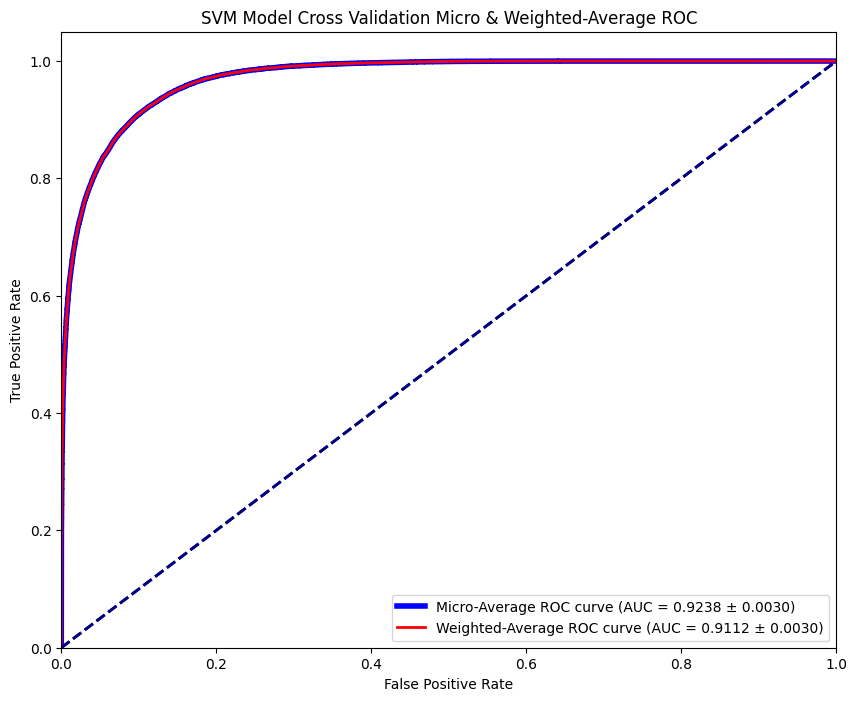

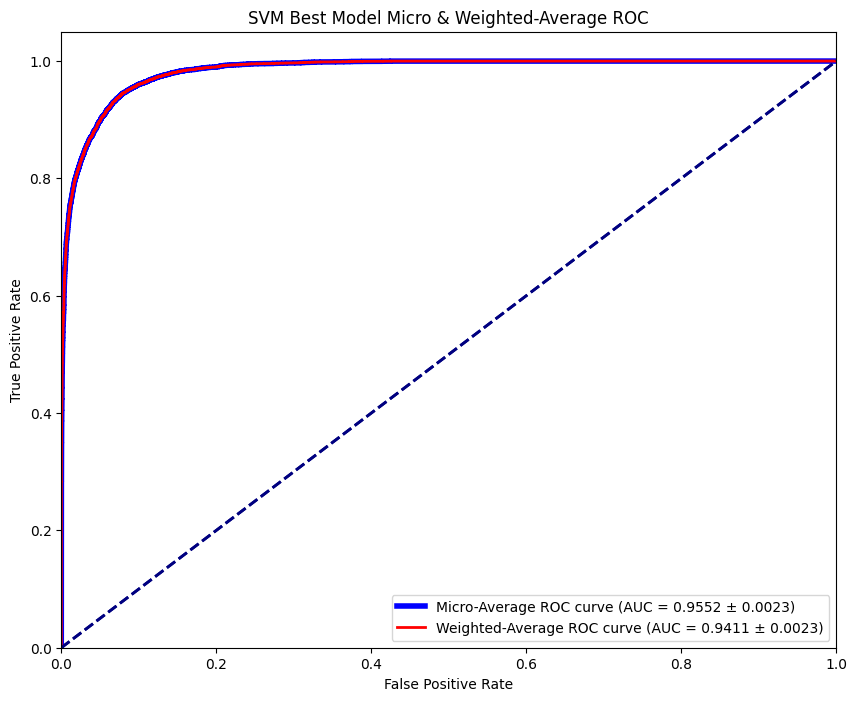

In [67]:
import matplotlib.pyplot as plt

micro_auc_cv=0.9238
micro_auc_cv_std=0.0030


weighted_auc_cv=0.9112
weighted_auc_cv_std=0.0030

# 绘制交叉验证的 AUC 和方差的 ROC 曲线
plt.figure(figsize=(10, 8))


# Micro-Average ROC Curve for cross-validation
plt.plot(fpr_micro_cv, tpr_micro_cv, color='blue', lw=4,
         label=f'Micro-Average ROC curve (AUC = {micro_auc_cv:.4f} ± {micro_auc_cv_std:.4f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM Model Cross Validation Micro & Weighted-Average ROC')
plt.legend(loc="lower right")

# Weighted-Average ROC Curve for cross-validation
plt.plot(fpr_weighted_cv, tpr_weighted_cv, color='red', lw=2,
         label=f'Weighted-Average ROC curve (AUC = {weighted_auc_cv:.4f} ± {weighted_auc_cv_std:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

micro_auc_best=0.9552
micro_auc_best_std=0.0023


weighted_auc_best=0.9411
weighted_auc_best_std=0.0023

# 绘制最佳参数模型的 AUC 和方差的 ROC 曲线
plt.figure(figsize=(10, 8))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Micro-Average ROC Curve for best model
plt.plot(fpr_micro_best, tpr_micro_best, color='blue', lw=4,
         label=f'Micro-Average ROC curve (AUC = {micro_auc_best:.4f} ± {micro_auc_best_std:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM Best Model Micro & Weighted-Average ROC')
plt.legend(loc="lower right")

# Weighted-Average ROC Curve for best model
plt.plot(fpr_weighted_best, tpr_weighted_best, color='red', lw=2,
         label=f'Weighted-Average ROC curve (AUC = {weighted_auc_best:.4f} ± {weighted_auc_best_std:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


# Random Forest Part

In [ ]:
# Create a random forest model and train it
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predictions on test sets
y_pred_rf = rf_model.predict(X_test_scaled)

# Calculating Accuracy, Precision, Recall and F1 Scores
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf, average='weighted')
recall = recall_score(y_test, y_pred_rf, average='weighted')
f1 = f1_score(y_test, y_pred_rf, average='weighted')

# print Performance Score
print("Model Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# print Confusion Matrix and Classification Report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, digits=4)) # set the number of decimal places to 4

In [ ]:
# Define the parameter grid for the random forest model
rf_param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Method of selecting samples for training each tree
}

# Create a random forest model
rf_model = RandomForestClassifier(random_state=42)

# Setting Grid Search Parameters
rf_grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param_grid,
    cv=10,  # 10-fold cross-validation
    scoring='accuracy',  # Use accuracy as the evaluation metric
    n_jobs=-1,  # Use all available CPU cores
    verbose=2
)

# Fit the model
rf_history = rf_grid_search.fit(X_train_scaled, y_train)

# print the best parameters and best model score
print("Best parameters found: ", rf_grid_search.best_params_)
print("Best cross-validation accuracy: ", rf_grid_search.best_score_)

### Accuracy of RF model hyperparametric combinations

In [ ]:
rf_results = pd.DataFrame(rf_grid_search.cv_results_)

rf_results_acc = rf_results[['params', 'mean_test_score', 'std_test_score']]

rf_results_acc

rf_results_acc.to_excel('rf_grid_search_results.xlsx', index=False)

print("Results saved to 'rf_grid_search_results.xlsx'")

In [45]:
rf_model = RandomForestClassifier(random_state=42)

# use the best model to make predictions
cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=10, scoring='accuracy', n_jobs=-1)

# Calculate the average accuracy
mean_accuracy = cv_scores.mean()

# print the accuracy of each fold and the average accuracy
print(f"Per-fold accuracy for 10-fold cross validation: {cv_scores}")
print(f"Average accuracy of 10-fold cross-validation: {mean_accuracy:.4f}")

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0

Per-fold accuracy for 10-fold cross validation: [0.84853052 0.84827933 0.84099472 0.84501382 0.85229842 0.84275308
 0.84275308 0.84827933 0.84371859 0.84497487]
Average accuracy of 10-fold cross-validation: 0.8458


In [ ]:
# use the best model to make predictions
best_model_rf = rf_grid_search.best_estimator_
y_pred_rf = best_model_rf.predict(X_test_scaled)

# Calculating Accuracy, Precision, Recall and F1 Scores
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf, average='weighted')
recall = recall_score(y_test, y_pred_rf, average='weighted')
f1 = f1_score(y_test, y_pred_rf, average='weighted')

# print Performance Score
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# print Performance Score
print("Model Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, digits=4)) # set the number of decimal places to 4

In [40]:
classes = [0, 1, 2, 3]
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin = label_binarize(y_test, classes=classes)

# 10-fold cross-validation
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
y_scores_cv = cross_val_predict(rf_model, X_train_scaled, y_train, cv=10, method="predict_proba", n_jobs=-1)

# compute Micro-Average AUC
micro_auc_cv = roc_auc_score(y_train_bin, y_scores_cv, average="micro")
micro_auc_cv_std = np.std(cross_val_score(rf_model, X_train_scaled, y_train, cv=10, scoring='roc_auc_ovr'))

# compute Weighted-Average AUC
weighted_auc_cv = roc_auc_score(y_train_bin, y_scores_cv, average="weighted")
weighted_auc_cv_std = np.std(cross_val_score(rf_model, X_train_scaled, y_train, cv=10, scoring='roc_auc_ovr'))

print(f"10fold cross validation Micro-Average AUC: Mean = {micro_auc_cv:.4f}, Std Dev = {micro_auc_cv_std:.4f}")
print(f"10fold cross validation Weighted-Average AUC: Mean = {weighted_auc_cv:.4f}, Std Dev = {weighted_auc_cv_std:.4f}")

10fold cross validation Micro-Average AUC: Mean = 0.9736, Std Dev = 0.0010
10fold cross validation Weighted-Average AUC: Mean = 0.9685, Std Dev = 0.0010


NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [41]:
# best model 
best_model_rf= RandomForestClassifier(n_estimators=200, max_depth=30, min_samples_leaf=1, min_samples_split=2, bootstrap=False, random_state=42)

best_model_rf.fit(X_train_scaled, y_train)

y_scores_best = best_model_rf.predict_proba(X_test_scaled)

# compute Micro-Average ROC curve
micro_auc_best = roc_auc_score(y_test_bin, y_scores_best, average="micro")
micro_auc_best_std = np.std(cross_val_score(best_model_rf, X_train_scaled, y_train, cv=10, scoring='roc_auc_ovr'))

# compute Weighted-Average ROC curve
weighted_auc_best = roc_auc_score(y_test_bin, y_scores_best, average="weighted")
weighted_auc_best_std = np.std(cross_val_score(best_model_rf, X_train_scaled, y_train, cv=10, scoring='roc_auc_ovr'))

print(f"The best Micro-Average AUC: Mean = {micro_auc_best:.4f}, Std Dev = {micro_auc_best_std:.4f}")
print(f"The best Weighted-Average AUC: Mean = {weighted_auc_best:.4f}, Std Dev = {weighted_auc_best_std:.4f}")

The best Micro-Average AUC: Mean = 0.9802, Std Dev = 0.0010
The best Weighted-Average AUC: Mean = 0.9756, Std Dev = 0.0010


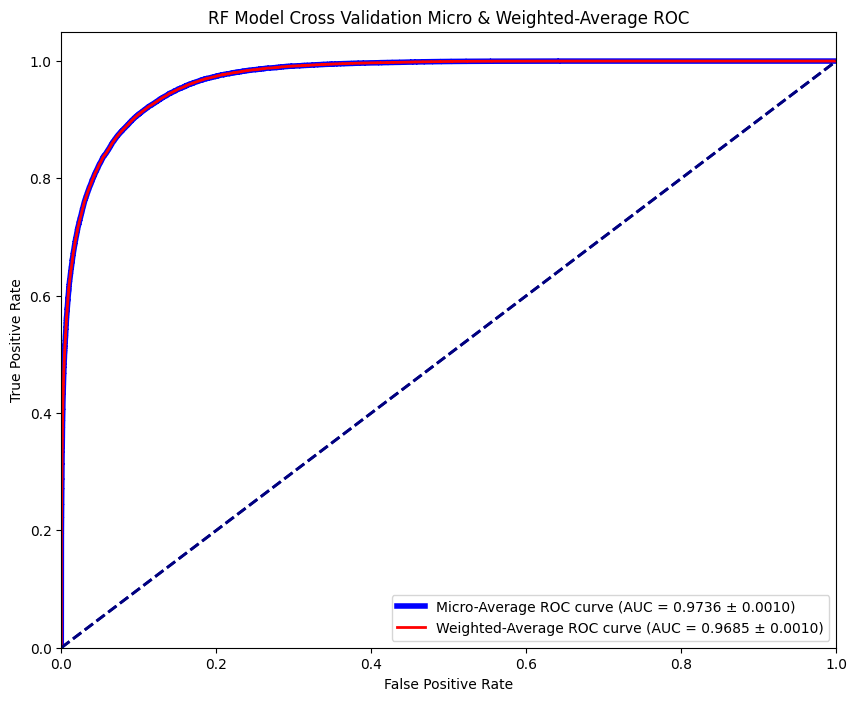

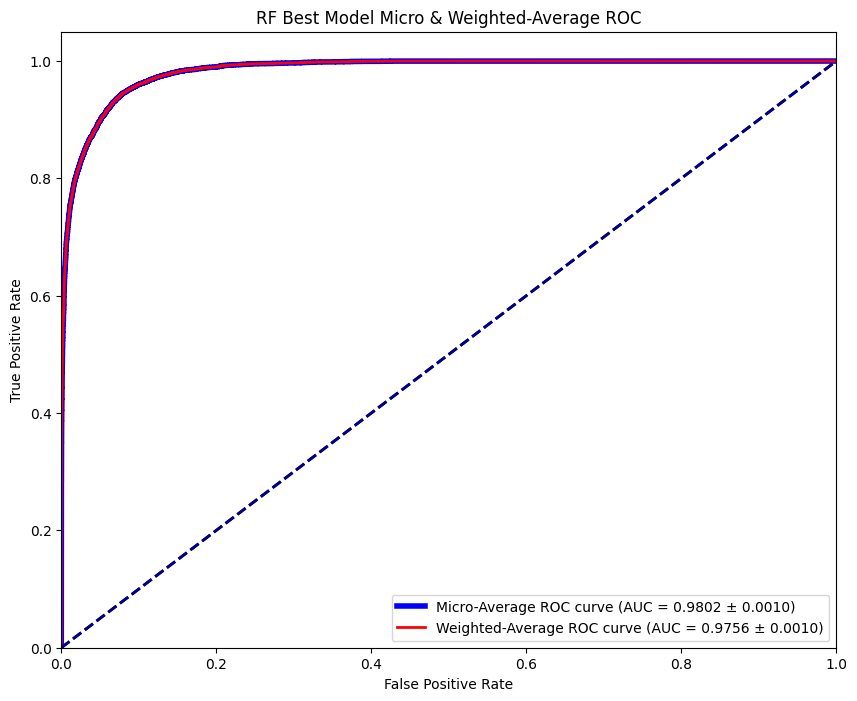

In [69]:
import matplotlib.pyplot as plt

micro_auc_cv=0.9736
micro_auc_cv_std=0.0010
weighted_auc_cv=0.9685
weighted_auc_cv_std=0.0010


# 绘制交叉验证的 AUC 和方差的 ROC 曲线
plt.figure(figsize=(10, 8))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Micro-Average ROC Curve for cross-validation
plt.plot(fpr_micro_cv, tpr_micro_cv, color='blue', lw=4,
         label=f'Micro-Average ROC curve (AUC = {micro_auc_cv:.4f} ± {micro_auc_cv_std:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF Model Cross Validation Micro & Weighted-Average ROC')
plt.legend(loc="lower right")

# Weighted-Average ROC Curve for cross-validation
plt.plot(fpr_weighted_cv, tpr_weighted_cv, color='red', lw=2,
         label=f'Weighted-Average ROC curve (AUC = {weighted_auc_cv:.4f} ± {weighted_auc_cv_std:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

micro_auc_best=0.9802
micro_auc_best_std=0.0010

weighted_auc_best=0.9756
weighted_auc_best_std=0.0010


# 绘制最佳参数模型的 AUC 和方差的 ROC 曲线
plt.figure(figsize=(10, 8))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Micro-Average ROC Curve for best model
plt.plot(fpr_micro_best, tpr_micro_best, color='blue', lw=4,
         label=f'Micro-Average ROC curve (AUC = {micro_auc_best:.4f} ± {micro_auc_best_std:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF Best Model Micro & Weighted-Average ROC')
plt.legend(loc="lower right")

# Weighted-Average ROC Curve for best model
plt.plot(fpr_weighted_best, tpr_weighted_best, color='red', lw=2,
         label=f'Weighted-Average ROC curve (AUC = {weighted_auc_best:.4f} ± {weighted_auc_best_std:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# XGBoost & LightGBM Model Part 

### XGBosot

In [ ]:
# Create a XGBoost model and train it
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_scaled, y_train)

# Predictions on test sets
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Calculating Accuracy, Precision, Recall and F1 Scores
accuracy = accuracy_score(y_test, y_pred_xgb)
precision = precision_score(y_test, y_pred_xgb, average='weighted')
recall = recall_score(y_test, y_pred_xgb, average='weighted')
f1 = f1_score(y_test, y_pred_xgb, average='weighted')

# print Performance 
print("Model Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# print Confusion Matrix and Classification Report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, digits=4)) # set the number of decimal places to 4

In [ ]:
# from sklearn.model_selection import GridSearchCV, KFold
# from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# create a XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Define the parameter grid for the XGBoost model
xgb_param_grid = {
    'n_estimators': [100, 200, 300],    # Number of trees
    'max_depth': [3, 5, 7],             # Maximum depth of the tree
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'subsample': [0.8, 1.0],            # Subsample ratio of the training instances
    'colsample_bytree': [0.8, 1.0]      # Subsample ratio of columns when constructing each tree
}

# Create a 10-fold cross-validation object
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Create a Grid Search object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train_scaled, y_train)

# print the best parameters and best model score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: ", grid_search.best_score_)

# use the best model to make predictions
best_xgb_model = grid_search.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test_scaled)

# Calculating Accuracy, Precision, Recall and F1 Scores
accuracy = accuracy_score(y_test, y_pred_xgb)
precision = precision_score(y_test, y_pred_xgb, average='weighted')
recall = recall_score(y_test, y_pred_xgb, average='weighted')
f1 = f1_score(y_test, y_pred_xgb, average='weighted')

# print Performance
print("\nModel Performance Metrics on Test Data:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# print Confusion Matrix and Classification Report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, digits=4))

### Accuracy of XGBoost model hyperparametric combinations

In [ ]:
xgboost_results = pd.DataFrame(grid_search.cv_results_)

xgboost_results_acc = xgboost_results[['params', 'mean_test_score', 'std_test_score']]

xgboost_results_acc

xgboost_results_acc.to_excel('xbg_grid_search_results.xlsx', index=False)

print("Results saved to 'xbg_grid_search_results.xlsx'")

In [50]:
xgb_model = XGBClassifier(colsample_bytree=1.0,learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.8, random_state=42)
# use the best model to make predictions
cv_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=10, scoring='accuracy', n_jobs=-1)

# Calculate the average accuracy
mean_accuracy = cv_scores.mean()

# print the accuracy of each fold and the average accuracy
print(f"Per-fold accuracy for 10-fold cross validation: {cv_scores}")
print(f"Average accuracy of 10-fold cross-validation: {mean_accuracy:.4f}")

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Per-fold accuracy for 10-fold cross validation: [0.87239387 0.87616177 0.87465461 0.86862597 0.87992967 0.86963075
 0.87591058 0.87289626 0.87160804 0.86909548]
Average accuracy of 10-fold cross-validation: 0.8731


### AUC for XGBoost

In [45]:
classes = [0, 1, 2, 3]
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin = label_binarize(y_test, classes=classes)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

y_scores_cv = cross_val_predict(xgb_model, X_train_scaled, y_train, cv=10, method="predict_proba", n_jobs=-1)

# compute Micro-Average AUC
micro_auc_cv = roc_auc_score(y_train_bin, y_scores_cv, average="micro")
micro_auc_cv_std = np.std(cross_val_score(xgb_model, X_train_scaled, y_train, cv=10, scoring='roc_auc_ovr'))

# 计算Weighted-Average AUC
weighted_auc_cv = roc_auc_score(y_train_bin, y_scores_cv, average="weighted")
weighted_auc_cv_std = np.std(cross_val_score(xgb_model, X_train_scaled, y_train, cv=10, scoring='roc_auc_ovr'))

print(f"10fold cross validation Micro-Average AUC: Mean = {micro_auc_cv:.4f}, Std Dev = {micro_auc_cv_std:.4f}")
print(f"10fold cross validation Weighted-Average AUC: Mean = {weighted_auc_cv:.4f}, Std Dev = {weighted_auc_cv_std:.4f}")

10fold cross validation Micro-Average AUC: Mean = 0.9782, Std Dev = 0.0007
10fold cross validation Weighted-Average AUC: Mean = 0.9745, Std Dev = 0.0007


In [46]:
best_xgb_model = XGBClassifier(colsample_bytree=1.0,learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.8, random_state=42)

best_xgb_model.fit(X_train_scaled, y_train)

# compute the auc for the best model
y_scores_best = best_xgb_model.predict_proba(X_test_scaled)

# compute Micro-Average ROC curve
micro_auc_best = roc_auc_score(y_test_bin, y_scores_best, average="micro")
micro_auc_best_std = np.std(cross_val_score(best_xgb_model, X_train_scaled, y_train, cv=10, scoring='roc_auc_ovr'))

# compute Weighted-Average ROC curve
weighted_auc_best = roc_auc_score(y_test_bin, y_scores_best, average="weighted")
weighted_auc_best_std = np.std(cross_val_score(best_xgb_model, X_train_scaled, y_train, cv=10, scoring='roc_auc_ovr'))

print(f"The best Micro-Average AUC: Mean = {micro_auc_best:.4f}, Std Dev = {micro_auc_best_std:.4f}")
print(f"The best Weighted-Average AUC: Mean = {weighted_auc_best:.4f}, Std Dev = {weighted_auc_best_std:.4f}")

The best Micro-Average AUC: Mean = 0.9841, Std Dev = 0.0009
The best Weighted-Average AUC: Mean = 0.9803, Std Dev = 0.0009


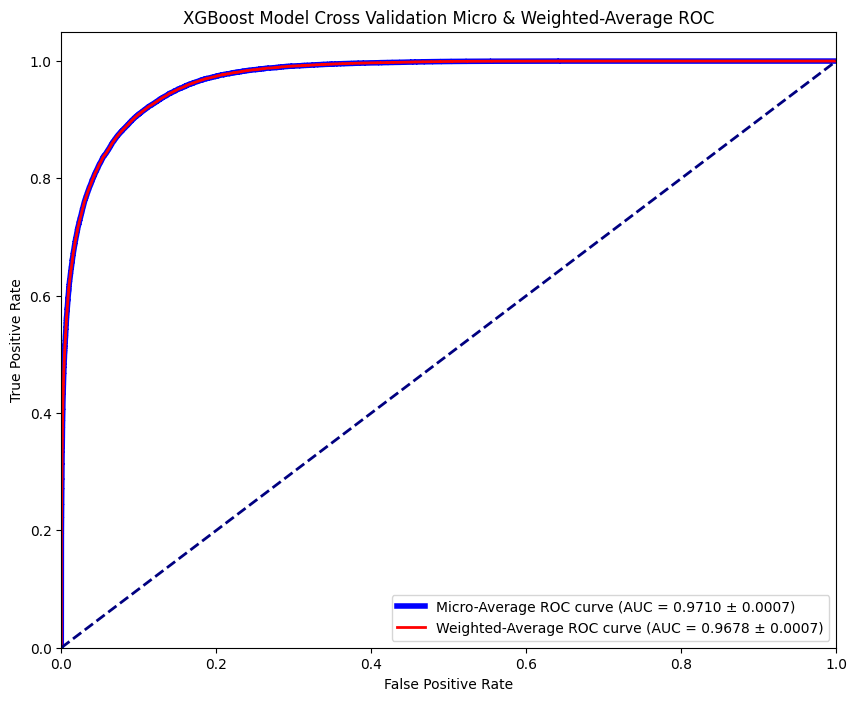

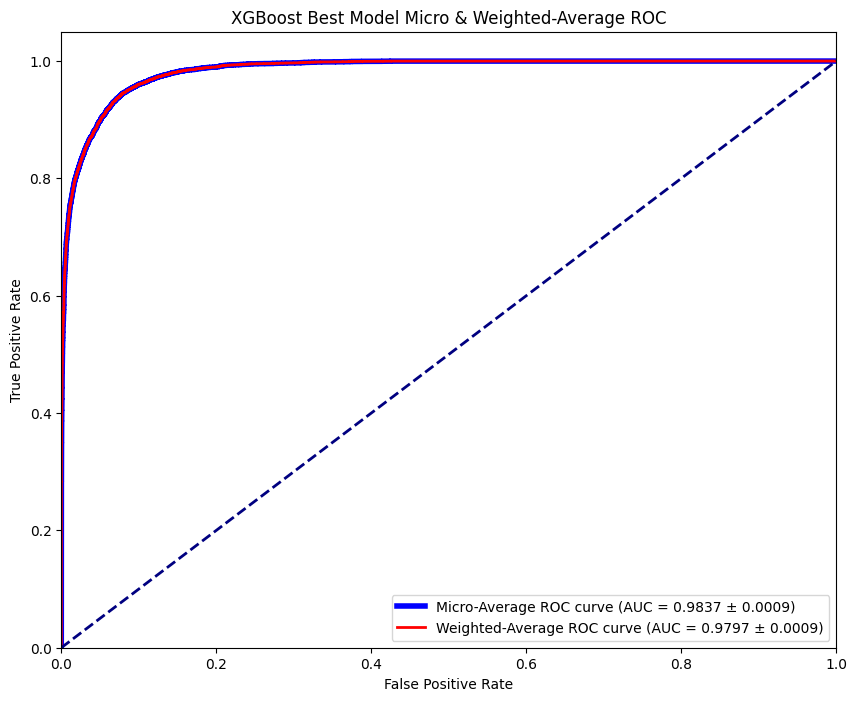

In [63]:
# plt the roc curve for 10-fold cross-validation
fpr_micro_cv, tpr_micro_cv, _ = roc_curve(y_train_bin.ravel(), y_scores_cv.ravel())
fpr_weighted_cv, tpr_weighted_cv, _ = roc_curve(y_train_bin.ravel(), y_scores_cv.ravel())

micro_auc_cv=0.9782
micro_auc_cv_std=0.0007
weighted_auc_cv=0.9745
weighted_auc_cv_std=0.0007

plt.figure(figsize=(10, 8))
plt.xlim([0.0, 1.0])

plt.ylim([0.0, 1.05])
plt.plot(fpr_micro_cv, tpr_micro_cv, color='blue', lw=4, label=f'Micro-Average ROC curve (AUC = {micro_auc_cv:.4f} ± {micro_auc_cv_std:.4f})')
plt.plot(fpr_weighted_cv, tpr_weighted_cv, color='red', lw=2, label=f'Weighted-Average ROC curve (AUC = {weighted_auc_cv:.4f} ± {weighted_auc_cv_std:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost Model Cross Validation Micro & Weighted-Average ROC')
plt.legend(loc="lower right")
plt.show()




# plt the roc curve for the best model
fpr_micro_best, tpr_micro_best, _ = roc_curve(y_test_bin.ravel(), y_scores_best.ravel())
fpr_weighted_best, tpr_weighted_best, _ = roc_curve(y_test_bin.ravel(), y_scores_best.ravel())

micro_auc_best=0.9841
micro_auc_best_std=0.0009

weighted_auc_best=0.9803
weighted_auc_best_std=0.0009



plt.figure(figsize=(10, 8))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.plot(fpr_micro_best, tpr_micro_best, color='blue', lw=4, label=f'Micro-Average ROC curve (AUC = {micro_auc_best:.4f} ± {micro_auc_best_std:.4f})')
plt.plot(fpr_weighted_best, tpr_weighted_best, color='red', lw=2, label=f'Weighted-Average ROC curve (AUC = {weighted_auc_best:.4f} ± {weighted_auc_best_std:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost Best Model Micro & Weighted-Average ROC')
plt.legend(loc="lower right")
plt.show()


# plt.plot([0, 1], [0, 1], linestyle='--', color='grey', lw=2)

# # 去掉网格
# plt.grid(False)

# # 设置图形的范围、标签、标题和图例
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.grid(False)
# plt.xlabel('False Positive Rate', fontsize=15)
# plt.ylabel('True Positive Rate', fontsize=15)
# plt.title('LR Best Model Micro & Weighted-Average ROC', fontsize=18)
# plt.legend(loc="lower right", fontsize=12)

# # 显示图形
# plt.show()



# LightGBM Model Part

In [ ]:
# create lightGBM_model
lightGBM_model = LGBMClassifier(
    objective='multiclass',
    num_class=len(y.unique()),
    boosting_type='gbdt',
    learning_rate=0.1,
    n_estimators=100,
    max_depth=5,
    random_state=42
)

#  fit model
lightGBM_model.fit(X_train_scaled, y_train)

# Predictions on test sets
y_pred_lightGBM = lightGBM_model.predict(X_test_scaled)

# Calculating Accuracy, Precision, Recall and F1 Scores
accuracy = accuracy_score(y_test, y_pred_lightGBM)
precision = precision_score(y_test, y_pred_lightGBM, average='weighted')
recall = recall_score(y_test, y_pred_lightGBM, average='weighted')
f1 = f1_score(y_test, y_pred_lightGBM, average='weighted')

# print Performance Score
print("Model Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# print Confusion Matrix and Classification Report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lightGBM))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lightGBM, digits=4)) # set the number of decimal places to 4


In [ ]:
# Define the parameter grid for the LightGBM model
lightGBM_param_grid = {
    'boosting_type': ['gbdt', 'dart'],  # Gradient Boosting Decision Tree
    'num_leaves': [31, 50, 100],        # Maximum number of leaves in one tree
    'max_depth': [-1, 10, 20],          # Maximum depth of the tree
    'learning_rate': [0.001, 0.01, 0.1, 0.2],  # 
    'n_estimators': [100, 200, 300],    # Number of trees
    'objective': ['multiclass'],        # multiclass
    'num_class': [4],                   # Number of classes
}

# create a LightGBM model
lightGBM_model = LGBMClassifier(random_state=42)

# Setting Grid Search Parameters
lightGBM_grid_search = GridSearchCV(
    estimator=lightGBM_model,
    param_grid=lightGBM_param_grid,
    cv=10,  # 
    scoring='accuracy',  # 
    n_jobs=-1,  # 
    verbose=2
)

# fit the model
lightGBM_grid_search.fit(X_train_scaled, y_train)

# print the best parameters and best model score
print("Best parameters found: ", lightGBM_grid_search.best_params_)
print("Best cross-validation accuracy: ", lightGBM_grid_search.best_score_)

In [ ]:
# use the best model to make predictions
best_lightGBM_model = lightGBM_grid_search.best_estimator_
y_pred_lightGBM = best_lightGBM_model.predict(X_test_scaled)

# Calculating Accuracy, Precision, Recall and F1 Scores
accuracy = accuracy_score(y_test, y_pred_lightGBM)
precision = precision_score(y_test, y_pred_lightGBM, average='weighted')
recall = recall_score(y_test, y_pred_lightGBM, average='weighted')
f1 = f1_score(y_test, y_pred_lightGBM, average='weighted')

# print Performance Score
print("\nModel Performance Metrics on Test Data:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# print Confusion Matrix and Classification Report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lightGBM))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lightGBM, digits=4)) # set the number of decimal places to 4

In [49]:
classes = [0, 1, 2, 3]
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin = label_binarize(y_test, classes=classes)

lightGBM_model = LGBMClassifier(
    objective='multiclass',
    num_class=4,
    boosting_type='gbdt',
    learning_rate=0.1,
    n_estimators=100,
    max_depth=5,
    random_state=42
)

y_scores_cv = cross_val_predict(lightGBM_model, X_train_scaled, y_train, cv=10, method="predict_proba", n_jobs=-1)

# compute Micro-Average AUC
micro_auc_cv = roc_auc_score(y_train_bin, y_scores_cv, average="micro")
micro_auc_cv_std = np.std(cross_val_score(xgb_model, X_train_scaled, y_train, cv=10, scoring='roc_auc_ovr'))

# 计算Weighted-Average AUC
weighted_auc_cv = roc_auc_score(y_train_bin, y_scores_cv, average="weighted")
weighted_auc_cv_std = np.std(cross_val_score(xgb_model, X_train_scaled, y_train, cv=10, scoring='roc_auc_ovr'))

print(f"10fold cross validation Micro-Average AUC: Mean = {micro_auc_cv:.4f}, Std Dev = {micro_auc_cv_std:.4f}")
print(f"10fold cross validation Weighted-Average AUC: Mean = {weighted_auc_cv:.4f}, Std Dev = {weighted_auc_cv_std:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5544
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5547
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=t

In [53]:
best_lightgbm_model = LGBMClassifier(objective='multiclass',
    num_class=4,
    boosting_type='gbdt',
    learning_rate=0.2,
    n_estimators=300,
    max_depth= -1,
    n_leaves=100,
    random_state=42)

best_lightgbm_model.fit(X_train_scaled, y_train)

# compute the auc for the best model
y_scores_best = best_lightgbm_model.predict_proba(X_test_scaled)

# compute Micro-Average ROC curve
micro_auc_best = roc_auc_score(y_test_bin, y_scores_best, average="micro")
micro_auc_best_std = np.std(cross_val_score(best_lightgbm_model, X_train_scaled, y_train, cv=10, scoring='roc_auc_ovr'))

# compute Weighted-Average ROC curve
weighted_auc_best = roc_auc_score(y_test_bin, y_scores_best, average="weighted")
weighted_auc_best_std = np.std(cross_val_score(best_lightgbm_model, X_train_scaled, y_train, cv=10, scoring='roc_auc_ovr'))

print(f"The best Micro-Average AUC: Mean = {micro_auc_best:.4f}, Std Dev = {micro_auc_best_std:.4f}")
print(f"The best Weighted-Average AUC: Mean = {weighted_auc_best:.4f}, Std Dev = {weighted_auc_best_std:.4f}")

[LightGBM] [Warning] Unknown parameter: n_leaves
[LightGBM] [Warning] Unknown parameter: n_leaves
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5553
[LightGBM] [Info] Number of data points in the train set: 39808, number of used features: 23
[LightGBM] [Info] Start training from score -1.385993
[LightGBM] [Info] Start training from score -1.386093
[LightGBM] [Info] Start training from score -1.386495
[LightGBM] [Info] Start training from score -1.386596
[LightGBM] [Warning] Unknown parameter: n_leaves
[LightGBM] [Warning] Unknown parameter: n_leaves
[LightGBM] [Warning] Unknown parameter: n_leaves
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5545
[LightGBM] [Info] Number of data points in the train s

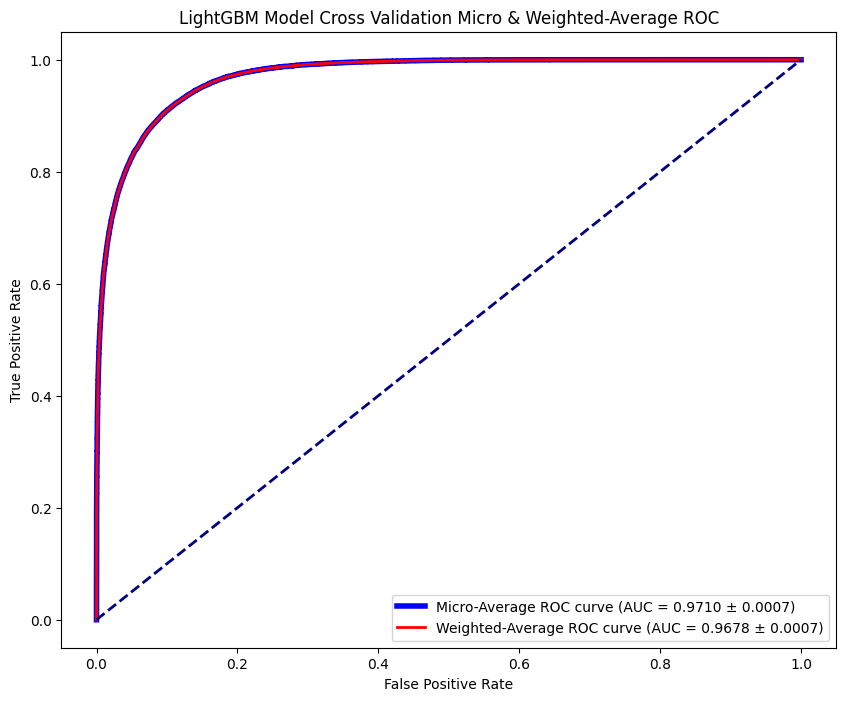

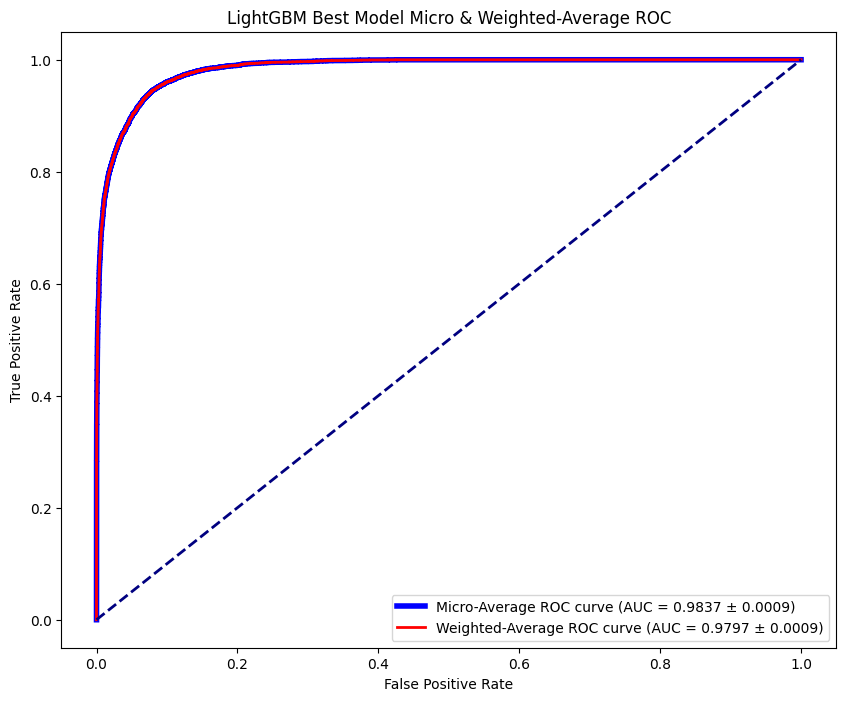

In [54]:
# plt the roc curve for 10-fold cross-validation
fpr_micro_cv, tpr_micro_cv, _ = roc_curve(y_train_bin.ravel(), y_scores_cv.ravel())
fpr_weighted_cv, tpr_weighted_cv, _ = roc_curve(y_train_bin.ravel(), y_scores_cv.ravel())

plt.figure(figsize=(10, 8))
plt.plot(fpr_micro_cv, tpr_micro_cv, color='blue', lw=4, label=f'Micro-Average ROC curve (AUC = {micro_auc_cv:.4f} ± {micro_auc_cv_std:.4f})')
plt.plot(fpr_weighted_cv, tpr_weighted_cv, color='red', lw=2, label=f'Weighted-Average ROC curve (AUC = {weighted_auc_cv:.4f} ± {weighted_auc_cv_std:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LightGBM Model Cross Validation Micro & Weighted-Average ROC')
plt.legend(loc="lower right")
plt.show()

# plt the roc curve for the best model
fpr_micro_best, tpr_micro_best, _ = roc_curve(y_test_bin.ravel(), y_scores_best.ravel())
fpr_weighted_best, tpr_weighted_best, _ = roc_curve(y_test_bin.ravel(), y_scores_best.ravel())

plt.figure(figsize=(10, 8))
plt.plot(fpr_micro_best, tpr_micro_best, color='blue', lw=4, label=f'Micro-Average ROC curve (AUC = {micro_auc_best:.4f} ± {micro_auc_best_std:.4f})')
plt.plot(fpr_weighted_best, tpr_weighted_best, color='red', lw=2, label=f'Weighted-Average ROC curve (AUC = {weighted_auc_best:.4f} ± {weighted_auc_best_std:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LightGBM Best Model Micro & Weighted-Average ROC')
plt.legend(loc="lower right")
plt.show()

### Accuracy of LightGBM model hyperparametric combinations

In [ ]:
lightGBM_results = pd.DataFrame(lightGBM_grid_search.cv_results_)

lightgbm_results_acc = lightGBM_results[['params', 'mean_test_score', 'std_test_score']]

lightgbm_results_acc

lightgbm_results_acc.to_excel('lightgbm_grid_search_results.xlsx', index=False)

print("Results saved to 'lightgbm_grid_search_results.xlsx'")

In [49]:
lightGBM_model = LGBMClassifier(
    boosting_type='gbdt', learning_rate=0.2, max_depth= -1, 
    n_estimators=300, num_class=4, num_leaves=100, objective='multiclass', random_state=42)

# 'boosting_type': 'gbdt', 'learning_rate': 0.2, 'max_depth': -1, 'n_estimators': 300, 'num_class': 4, 'num_leaves': 100, 'objective': 'multiclass
# use the best model to make predictions
cv_scores = cross_val_score(lightGBM_model, X_train_scaled, y_train, cv=10, scoring='accuracy', n_jobs=-1)

# Calculate the average accuracy
mean_accuracy = cv_scores.mean()

# print the accuracy of each fold and the average accuracy
print(f"Per-fold accuracy for 10-fold cross validation: {cv_scores}")
print(f"Average accuracy of 10-fold cross-validation: {mean_accuracy:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5547
[LightGBM] [Info] Number of data points in the train set: 35827, number of used features: 23
[LightGBM] [Info] Start training from score -1.386043
[LightGBM] [Info] Start training from score -1.386043
[LightGBM] [Info] Start training from score -1.386490
[LightGBM] [Info] Start training from score -1.386601
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5548
[LightGBM

# CNN Model Part 

In [15]:
# Separate features and target variables
X_cnn = df_numeric_imputed.drop('survival_category', axis=1).values
y_cnn = df_numeric_imputed['survival_category'].values

# standardize the features
scaler = StandardScaler()
X_scaled_cnn = scaler.fit_transform(X_cnn)

# one-hot encode the target variable
y_categorical_cnn = to_categorical(y_cnn)

# Split the data into training and testing sets
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_scaled_cnn, y_categorical_cnn, test_size=0.2, random_state=42)

# check the shape of the training and testing sets
print(f"training num: {X_train_cnn.shape[0]}, features: {X_train_cnn.shape[1]}")
print(f"testing num: {X_test_cnn.shape[0]}, features: {X_test_cnn.shape[1]}")
print(f"training num: {y_train_cnn.shape[0]}, features: {y_train_cnn.shape[1]}")
print(f"testing num: {y_test_cnn.shape[0]}, features: {y_test_cnn.shape[1]}")

training num: 21496, features: 27
testing num: 5374, features: 27
training num: 21496, features: 4
testing num: 5374, features: 4


In [16]:
from keras.regularizers import l1_l2

# 调整输入数据的形状以适应Conv1D
X_train_cnn = X_train_cnn.reshape((X_train_cnn.shape[0], X_train_cnn.shape[1], 1))
X_test_cnn = X_test_cnn.reshape((X_test_cnn.shape[0], X_test_cnn.shape[1], 1))


cnn_model = Sequential()

# because of the data, using Conv1D
cnn_model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Conv1D(64, kernel_size=3, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))) # add regularization
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(y_categorical_cnn.shape[1], activation='softmax'))

# compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# fit model 
X_train_cnn = X_train_cnn.reshape((X_train_cnn.shape[0], X_train_cnn.shape[1], 1))  # 添加一个维度用于Conv1D
X_test_cnn = X_test_cnn.reshape((X_test_cnn.shape[0], X_test_cnn.shape[1], 1))

# set early_stopping
cnn_early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

/Users/tyh/Library/Python/3.12/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [60]:
cnn_model.fit(X_train_cnn, y_train_cnn, epochs=50, batch_size=32, 
                          validation_data=(X_test_cnn, y_test_cnn), 
                          callbacks=[cnn_early_stopping], verbose=2)

# evaluate the model
loss, accuracy = cnn_model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print(f"the accuracy of testing set: {accuracy:.4f}")

# plot the training history
y_pred_cnn = cnn_model.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred_cnn, axis=1)
y_true_classes = np.argmax(y_test_cnn, axis=1)

# calculate the performance metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

# print the performance metrics
print("\nModel Performance Metrics on Test Data:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nconfusion matirx:")
print(confusion_matrix(y_true_classes, y_pred_classes))

print("\nclassification_report:")
print(classification_report(y_true_classes, y_pred_classes, digits=4)) # set the number of decimal places to 4

Epoch 1/50
672/672 - 5s - 7ms/step - accuracy: 0.4813 - loss: 2.7435 - val_accuracy: 0.5625 - val_loss: 1.0131
Epoch 2/50
672/672 - 3s - 4ms/step - accuracy: 0.6667 - loss: 0.8997 - val_accuracy: 0.8459 - val_loss: 0.7361
Epoch 3/50
672/672 - 3s - 4ms/step - accuracy: 0.8623 - loss: 0.6001 - val_accuracy: 0.8980 - val_loss: 0.5112
Epoch 4/50
672/672 - 3s - 4ms/step - accuracy: 0.8807 - loss: 0.5304 - val_accuracy: 0.9014 - val_loss: 0.4486
Epoch 5/50
672/672 - 3s - 5ms/step - accuracy: 0.8936 - loss: 0.4756 - val_accuracy: 0.9066 - val_loss: 0.4496
Epoch 6/50
672/672 - 3s - 5ms/step - accuracy: 0.8976 - loss: 0.4631 - val_accuracy: 0.9127 - val_loss: 0.4428
Epoch 7/50
672/672 - 3s - 4ms/step - accuracy: 0.9005 - loss: 0.4486 - val_accuracy: 0.9168 - val_loss: 0.4125
Epoch 8/50
672/672 - 3s - 5ms/step - accuracy: 0.9061 - loss: 0.4448 - val_accuracy: 0.9239 - val_loss: 0.4241
Epoch 9/50
672/672 - 4s - 6ms/step - accuracy: 0.9040 - loss: 0.4539 - val_accuracy: 0.9207 - val_loss: 0.3866
E

In [ ]:
# plot the training and validation loss
plt.figure(figsize=(6, 4))
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('CNN Model - Loss Fuction Trend')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [88]:
# Adjust the shape of the input data to fit Conv1D
X_train_cnn = X_train_cnn.reshape((X_train_cnn.shape[0], X_train_cnn.shape[1], 1))
X_test_cnn = X_test_cnn.reshape((X_test_cnn.shape[0], X_test_cnn.shape[1], 1))

In [ ]:

from keras.models import Model, Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout

def create_cnn_model(optimizer='adam', dropout_rate=0.5):
    input_layer = Input(shape=(X_cnn.shape[1], 1))
    x = Conv1D(32, kernel_size=3, activation='relu')(input_layer)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(64, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(x)
    x = Dropout(dropout_rate)(x)
    output_layer = Dense(4, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Wrapping Models with Scikeras' KerasClassifier
cnn_classifier = KerasClassifier(model=create_cnn_model, epochs=10, batch_size=32, verbose=2)

# define param_grid
param_grid = {
    'model__optimizer': ['adam', 'rmsprop'],
    'model__dropout_rate': [0.3, 0.5, 0.7],
    'batch_size': [32, 64, 128],
    'epochs': [20, 30, 50]
}

# 
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

#  set Grid Search
cnn_grid_search = GridSearchCV(estimator=cnn_classifier, param_grid=param_grid, cv=kfold, n_jobs=-1, verbose=2)

# fit the model by Grid Search
cnn_grid_search.fit(X_scaled_cnn.reshape((X_scaled_cnn.shape[0], X_scaled_cnn.shape[1], 1)), y_categorical_cnn, verbose=1)


# print the best parameters and best model score
print("Best parameters found: ", cnn_grid_search.best_params_)
print("Best cross-validation accuracy: ", cnn_grid_search.best_score_)

# use the best model to make predictions
best_cnn_model = cnn_grid_search.best_estimator_
y_pred_cnn = best_cnn_model.predict(X_test_cnn)

# compute the confusion matrix and classification report
y_pred_classes = np.argmax(y_pred_cnn, axis=1)
y_true_classes = np.argmax(y_test_cnn, axis=1)

# calculate the performance metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

# print Performance 
print("\nModel Performance Metrics on Test Data:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\n confusion_matrix:")
print(confusion_matrix(y_true_classes, y_pred_classes))

print("\n classification_report:")
print(classification_report(y_true_classes, y_pred_classes, digits=4)) # set the number of decimal places to 4

In [ ]:
cnn_results = pd.DataFrame(cnn_grid_search.cv_results_)

cnn_results_acc = cnn_results[['params', 'mean_test_score', 'std_test_score']]

cnn_results_acc

cnn_results_acc.to_excel('cnn_grid_search_results.xlsx', index=False)

print("Results saved to 'cnn_grid_search_results.xlsx'")

In [164]:
classes = [0, 1, 2, 3]

# Ensure that X_train_scaled is reshaped properly for CNN
# X_train_scaled_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))

# 训练模型
X_train_cnn = X_train_cnn.reshape((X_train_cnn.shape[0], X_train_cnn.shape[1], 1))  # 添加一个维度用于Conv1D
X_test_cnn = X_test_cnn.reshape((X_test_cnn.shape[0], X_test_cnn.shape[1], 1))

def create_cnn_model(optimizer='adam', dropout_rate=0.5):
    input_layer = Input(shape=(X_train_scaled.shape[1], 1))
    x = Conv1D(32, kernel_size=3, activation='relu')(input_layer)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(64, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(x)
    x = Dropout(dropout_rate)(x)
    output_layer = Dense(4, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


cnn_early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 确保输入数据的形状适合Conv1D
# X_train_cnn = X_scaled_cnn.reshape((X_scaled_cnn.shape[0], X_scaled_cnn.shape[1], 1))

# 定义CNN模型包装器
cnn_classifier = KerasClassifier(model=create_cnn_model, batch_size=64, epochs=30, dropout_rate=0.5, 
                                 optimizer='adam', random_state=42, verbose=2)

# 设置10折交叉验证
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# 计算交叉验证的准确率
cv_scores = cross_val_score(cnn_classifier, X_train_cnn, y_train_cnn, cv=kfold, scoring='accuracy', n_jobs=-1)

# 打印每折的准确率和平均准确率
print(f"Per-fold accuracy for 10-fold cross-validation: {cv_scores}")
print(f"Average accuracy of 10-fold cross-validation: {cv_scores.mean():.4f}")


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0

Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30
560/560 - 5s - 8ms/step - accuracy: 0.4121 - loss: 3.0604
Epoch 2/30
560/560 - 5s - 8ms/step - accuracy: 0.4248 - loss: 3.0373
560/560 - 5s - 8ms/step - accuracy: 0.4127 - loss: 3.0268
Epoch 2/30
Epoch 2/30
560/560 - 5s - 8ms/step - accuracy: 0.4269 - loss: 3.0166
Epoch 2/30
560/560 - 5s - 8ms/step - accuracy: 0.4249 - loss: 3.0198
Epoch 2/30
560/560 - 5s - 8ms/step - accuracy: 0.4206 - loss: 3.0220
Epoch 2/30
560/560 - 5s - 8ms/step - accuracy: 0.4179 - loss: 3.0273
Epoch 2/30
560/560 - 5s - 8ms/step - accuracy: 0.4152 - loss: 3.0241
Epoch 2/30
560/560 - 5s - 9ms/step - accuracy: 0.4190 - loss: 3.0269
Epoch 2/30
560/560 - 5s - 9ms/step - accuracy: 0.4044 - loss: 3.0524
Epoch 2/30
560/560 - 2s - 4ms/step - accuracy: 0.5471 - loss: 1.0969
Epoch 3/30
560/560 - 2s - 4ms/step - accuracy: 0.5493 - loss: 1.1031
560/560 - 2s - 4ms/step - accuracy: 0.5481 - loss: 1.1010
Epoch 3/30
Epoc

In [30]:
# test
X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
y_train_cnn = to_categorical(y_train, num_classes=4)  # 假设4个类别

def create_cnn_model(optimizer='adam', dropout_rate=0.5):
    input_layer = Input(shape=(X_train_cnn.shape[1], 1))  # 使用X_train_cnn的形状
    x = Conv1D(32, kernel_size=3, activation='relu')(input_layer)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(64, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')#, kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(x)
    x = Dropout(dropout_rate)(x)
    output_layer = Dense(4, activation='softmax')(x)  # 假设有4个类别
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model



In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize

n_classes = 4

# Binarize the labels for multi-class ROC AUC
y_categorical_cnn = label_binarize(y_train_cnn, classes=[0, 1, 2, 3])

# 10-Fold Cross-Validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_micro_aucs = []
cv_weighted_aucs = []
mean_fpr = np.linspace(0, 1, 100)
tprs_micro = []
tprs_weighted = []

for train_idx, val_idx in kfold.split(X_train_cnn, np.argmax(y_train_cnn, axis=1)):
    X_train_fold, X_val_fold = X_train_cnn[train_idx], X_train_cnn[val_idx]
    y_train_fold, y_val_fold = y_categorical_cnn[train_idx], y_categorical_cnn[val_idx]

    # Reshape for Conv1D input
    X_train_fold = X_train_fold.reshape((X_train_fold.shape[0], X_train_fold.shape[1], 1))
    X_val_fold = X_val_fold.reshape((X_val_fold.shape[0], X_val_fold.shape[1], 1))

    # Train the model
    best_cnn_model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)

    # Predict probabilities
    y_pred_fold = best_cnn_model.predict(X_val_fold)

    # Calculate AUC for each fold
    micro_auc = roc_auc_score(y_val_fold, y_pred_fold, average='micro')
    weighted_auc = roc_auc_score(y_val_fold, y_pred_fold, average='weighted')

    cv_micro_aucs.append(micro_auc)
    cv_weighted_aucs.append(weighted_auc)

    # Compute ROC curve and AUC for micro-average
    fpr_micro, tpr_micro, _ = roc_curve(y_val_fold.ravel(), y_pred_fold.ravel())
    tprs_micro.append(np.interp(mean_fpr, fpr_micro, tpr_micro))
    tprs_micro[-1][0] = 0.0

# Calculate mean and std deviation of the AUCs
cv_micro_auc_mean = np.mean(cv_micro_aucs)
cv_micro_auc_std = np.std(cv_micro_aucs)
cv_weighted_auc_mean = np.mean(cv_weighted_aucs)
cv_weighted_auc_std = np.std(cv_weighted_aucs)

# Plotting the results
plt.figure(figsize=(10, 8))

# Plotting the micro-average ROC curve
mean_tpr_micro = np.mean(tprs_micro, axis=0)
mean_tpr_micro[-1] = 1.0
mean_auc_micro = auc(mean_fpr, mean_tpr_micro)
plt.plot(mean_fpr, mean_tpr_micro, color='blue', linestyle='-', lw=5,
         label=f'Micro-Average ROC (AUC = {cv_micro_auc_mean:.4f} ± {cv_micro_auc_std:.4f})')

# Plotting the weighted-average ROC curve
plt.plot(mean_fpr, mean_tpr_micro, color='red', linestyle='-', lw=2,
         label=f'Weighted-Average ROC (AUC = {cv_weighted_auc_mean:.4f} ± {cv_weighted_auc_std:.4f})')

# Diagonal line (random guessing)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('10-Fold Cross-Validation ROC Curves for CNN Model')
plt.legend(loc='lower right')
# 去掉网格
plt.grid(False)

plt.show()

print(f"10-Fold Cross-Validation Micro-Average AUC: Mean = {cv_micro_auc_mean:.4f}, Std Dev = {cv_micro_auc_std:.4f}")
print(f"10-Fold Cross-Validation Weighted-Average AUC: Mean = {cv_weighted_auc_mean:.4f}, Std Dev = {cv_weighted_auc_std:.4f}")


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

n_classes = 4

# Binarize the test labels for AUC calculation
y_test_binarized = label_binarize(y_test_cnn, classes=[0, 1, 2, 3])

# Predict probabilities
y_pred_proba = best_cnn_model.predict_proba(X_test_cnn)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_pred_proba[:, i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = roc_auc_score(y_test_binarized, y_pred_proba, average="micro")

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]) * np.sum(y_test_binarized[:, i])

# Average it and compute AUC
mean_tpr /= np.sum(y_test_binarized)
roc_auc["weighted"] = np.trapz(mean_tpr, all_fpr)

# Compute the standard deviation of the AUC
micro_auc_std = np.std([roc_auc[i] for i in range(n_classes)])
weighted_auc_std = np.std([roc_auc[i] for i in range(n_classes)])

# plt roc curve
plt.figure(figsize=(10, 8))

# Micro-Average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-Average ROC (AUC = {roc_auc["micro"]:.4f} ± {micro_auc_std:.4f})', color='blue', linestyle='-',lw=5)

# Weighted-Average ROC curve
plt.plot(all_fpr, mean_tpr, label=f'Weighted-Average ROC (AUC = {roc_auc["weighted"]:.4f} ± {weighted_auc_std:.4f})', color='red', linestyle='-',lw=2)

# Diagonal line (random guessing)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for CNN Model')

plt.legend(loc="lower right")
plt.grid(False)  # drop the grid
plt.show()

# print the AUC values
print(f"Micro-Average AUC: {roc_auc['micro']:.4f} ± {micro_auc_std:.4f}")
print(f"Weighted-Average AUC: {roc_auc['weighted']:.4f} ± {weighted_auc_std:.4f}")
